In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install -q transformers accelerate timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

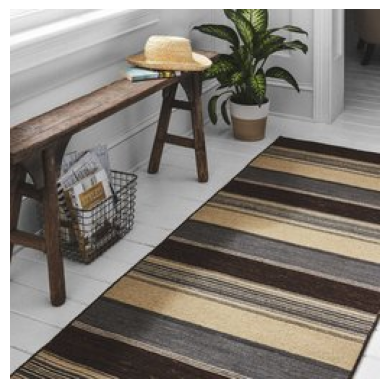

In [13]:
df = pd.read_csv("/kaggle/input/vrproject/Sf/Sf_qa_data_cleaned.csv", header=None, names=["img_path", "question", "answer"])
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the image path
img_path = "/kaggle/input/vrproject/Sf/Sf_images/0000b301.jpg"  # Change this to one of your image paths

# Check if the image path exists
if os.path.exists(img_path):
    # Open the image
    image = Image.open(img_path)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
else:
    print(f"Error: Image not found at {img_path}")


In [21]:
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import torch
import pandas as pd
import os

# Load CSV
df = pd.read_csv("/kaggle/input/vrproject/Sf/Sf_qa_data_cleaned.csv", header=None, names=["img_path", "question", "answer"])

# Clean up image path if needed
img_filename = os.path.basename(df.iloc[0]["img_path"])
img_path = f"/kaggle/input/vrproject/Sf/Sf_images/{img_filename}"
question = df.iloc[0]['question']

# Load the image
image = Image.open(img_path).convert("RGB")

# Load model and processor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# Preprocess
inputs = processor(image, question, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_id = logits.argmax(-1).item()
    answer = model.config.id2label[predicted_id]

print(f"Question: {question}")
print(f"Answer: {answer}")


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

Question: What is the main color of the feather?
Answer: red


In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import torch
import pandas as pd
import os
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, f1_score

# Load CSV
df = pd.read_csv("/kaggle/input/vrproject/Sf/Sf_qa_data_cleaned.csv", header=None, names=["img_path", "question", "answer"])

# Load model and processor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

results = []
y_true = []
y_pred = []

start_time = time.time()

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    img_filename = os.path.basename(row["img_path"])
    img_path = f"/kaggle/input/vrproject/Sf/Sf_images/{img_filename}"
    question = row["question"]
    true_answer = str(row["answer"]).strip().lower()
    
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = processor(image, question, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)
            predicted_id = outputs.logits.argmax(-1).item()
            pred_answer = model.config.id2label[predicted_id].strip().lower()
    except Exception as e:
        pred_answer = "error"

    results.append({
        "img_path": img_filename,
        "question": question,
        "true_answer": true_answer,
        "predicted_answer": pred_answer
    })

    y_true.append(true_answer)
    y_pred.append(pred_answer)

# Save predictions
results_df = pd.DataFrame(results)
results_df.to_csv("vilt_vqa_predictions.csv", index=False)

# Compute accuracy and F1 score
# (using macro average for F1 in case of multiple labels)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Save metrics
metrics_df = pd.DataFrame([{"accuracy": accuracy, "f1_score": f1}])
metrics_df.to_csv("vilt_vqa_metrics.csv", index=False)

elapsed = time.time() - start_time
print(f"Done. Total time: {elapsed:.2f} seconds ({elapsed / len(df):.2f} sec/image)")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (macro): {f1:.4f}")


In [ ]:
from shutil import copyfile

# Move results to a known visible path
copyfile("vilt_vqa_predictions.csv", "/kaggle/working/vilt_vqa_predictions.csv")


In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import torch
import pandas as pd
import os
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, f1_score

# Paths
csv_path = "/kaggle/input/vrproject/Sf/Sf_qa_data_cleaned.csv"
pred_path = "/kaggle/working/vilt_vqa_predictions.csv"
metrics_path = "/kaggle/working/vilt_vqa_metrics.csv"

# Load CSV
df = pd.read_csv(csv_path, header=None, names=["img_path", "question", "answer"])

# Load model and processor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# Resume support
start_idx = 0
if os.path.exists(pred_path):
    existing = pd.read_csv(pred_path)
    start_idx = len(existing)
    print(f"Resuming from index {start_idx}")
else:
    existing = pd.DataFrame()

# Storage
results = []
y_true = []
y_pred = []

start_time = time.time()

for idx in tqdm(range(start_idx, len(df)), desc="Processing"):
    row = df.iloc[idx]
    img_filename = os.path.basename(row["img_path"])
    img_path = f"/kaggle/input/vrproject/Sf/Sf_images/{img_filename}"
    question = row["question"]
    true_answer = str(row["answer"]).strip().lower()

    try:
        image = Image.open(img_path).convert("RGB")
        inputs = processor(image, question, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)
            predicted_id = outputs.logits.argmax(-1).item()
            pred_answer = model.config.id2label[predicted_id].strip().lower()
    except Exception as e:
        pred_answer = "error"

    results.append({
        "img_path": img_filename,
        "question": question,
        "true_answer": true_answer,
        "predicted_answer": pred_answer
    })

    y_true.append(true_answer)
    y_pred.append(pred_answer)

    # Save every 1000 or last item
    if (idx + 1) % 1000 == 0 or (idx + 1) == len(df):
        # Convert to DataFrame
        chunk_df = pd.DataFrame(results)
    
        if not os.path.exists(pred_path):
            # Write with header if file does not exist
            chunk_df.to_csv(pred_path, mode='w', index=False, header=True)
        else:
            # Append without header
            chunk_df.to_csv(pred_path, mode='a', index=False, header=False)
    
        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        metrics_entry = pd.DataFrame([{"step": idx + 1, "accuracy": accuracy, "f1_score": f1}])
    
        if not os.path.exists(metrics_path):
            metrics_entry.to_csv(metrics_path, mode='w', index=False, header=True)
        else:
            metrics_entry.to_csv(metrics_path, mode='a', index=False, header=False)
    
        # Reset for next chunk
        results, y_true, y_pred = [], [], []
    
        print(f"Checkpoint saved at index {idx + 1}")


elapsed = time.time() - start_time
print(f"Done. Total time: {elapsed:.2f}s")


Resuming from index 1000


Processing:   1%|          | 1001/96058 [03:44<5:24:56,  4.88it/s]

Checkpoint saved at index 2000


Processing:   2%|▏         | 2001/96058 [07:29<5:39:49,  4.61it/s]

Checkpoint saved at index 3000


Processing:   3%|▎         | 3000/96058 [11:08<5:52:29,  4.40it/s]

Checkpoint saved at index 4000


Processing:   4%|▍         | 4000/96058 [14:48<5:38:20,  4.53it/s]

Checkpoint saved at index 5000


Processing:   5%|▌         | 5000/96058 [18:24<5:21:54,  4.71it/s]

Checkpoint saved at index 6000


Processing:   5%|▌         | 5083/96058 [18:42<5:44:13,  4.40it/s]